# Fine-tuning ESM-2 for Protein Subcellular Localization Classification

---

#### *Describe your input data to the transformer model - what are your tokens? Show a plot of how the protein sequence data is distributed in terms of sequence lengths.*

## 1. Environment Setup and Configuration
Setting up the environment with all required packages for ESM-2 fine-tuning.


In [1]:
!pip install transformers datasets biopython fair-esm evaluate
!pip install accelerate>=0.26.0
from google.colab import files
uploaded = files.upload()

Saving uniprot_protein_data_assigment.csv to uniprot_protein_data_assigment (1).csv


---
## 2. Library Imports and Dependencies

Importing all essential libraries for data processing, model training, and comprehensive visualization.

In [2]:
# Section 2: Library Imports and Dependencies

# Core data processing and numerical libraries
import os
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from collections import Counter
import plotly.io as pio
pio.renderers.default = "png"

# Machine learning and evaluation libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
)

# Deep learning libraries
import torch

# Transformers for deep learning and ESM models
from transformers import (
    EsmTokenizer, EsmForSequenceClassification, TrainingArguments, Trainer, EsmConfig
)

# Datasets library for handling datasets
from datasets import Dataset

# ESM package from fair-esm
import esm
from esm import ESM2, Alphabet, BatchConverter

# Evaluation metrics
from evaluate import load

# Additional imports
from time import time

# Set visualization styles for professional plots
plt.style.use('default')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
sns.set_palette("husl")

---
## 3. Reproducibility and Model Configuration

Setting up reproducible experiments and confirming the ESM-2 model configuration for optimal results.

In [3]:
# Set comprehensive random seeds for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    # Additional CUDA settings for reproducibility
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# Configure device and verify model specification
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
# Verify the pre-specified ESM-2 model
model_name = "facebook/esm2_t6_8M_UR50D"  # Already defined in the notebook
print(f" Target model: {model_name}")

 Target model: facebook/esm2_t6_8M_UR50D


---
## 4. Data Loading and Exploration

Loading the UniProt protein dataset and performing comprehensive initial data analysis.


In [6]:
# Load Data
df = pd.read_csv('uniprot_protein_data_assigment.csv', index_col=0)
df = df.dropna() # Remove missing values

In [7]:
# Display comprehensive dataset overview
print("DATASET OVERVIEW:")
print(f"Dataset shape: {df.shape[0]:,} samples × {df.shape[1]} columns")
print(f"Column names: {list(df.columns)}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

print("\nFirst 3 rows:")
print(df.head(3))

DATASET OVERVIEW:
Dataset shape: 3,585 samples × 4 columns
Column names: ['Entry', 'Sequence', 'Subcellular location [CC]', 'label']
Memory usage: 2.29 MB

First 3 rows:
    Entry                                           Sequence  \
0                                                              
0  A0JLT2  MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPP...   
1  A0PJY2  MDSSCHNATTKMLATAPARGNMMSTSKPLAFSIERIMARTPEPKAL...   
2  A0PK00  MSGQLERCEREWHELEGEFQELQETHRIYKQKLEELAALQTLCSSS...   

                           Subcellular location [CC]  label  
0                                                            
0       SUBCELLULAR LOCATION: Nucleus {ECO:0000305}.      1  
1  SUBCELLULAR LOCATION: Nucleus {ECO:0000269|Pub...      1  
2  SUBCELLULAR LOCATION: Nucleus inner membrane {...      1  


---
## **5. Data Quality Assessment**

Comprehensive evaluation of data integrity and quality for model training preparation.

### **5.1 Data Quality Evaluation**

In [8]:
# Thorough data quality assessment
print("DATA QUALITY ASSESSMENT:")

print("Missing Values Analysis:")
missing_values = df.isnull().sum()
print(missing_values)
print(f"Total missing values: {missing_values.sum()}")

print(f"\nDuplicate Analysis:")
duplicate_sequences = df.duplicated(subset=['Sequence']).sum()
print(f"Duplicate sequences: {duplicate_sequences:,}")

print(f"\nData Types:")
print(df.dtypes)

if missing_values.sum() == 0 and duplicate_sequences == 0:
    print("\n Data quality excellent: No missing values or duplicates!")
else:
    print(f"\n Data quality issues detected - review before training")

DATA QUALITY ASSESSMENT:
Missing Values Analysis:
Entry                        0
Sequence                     0
Subcellular location [CC]    0
label                        0
dtype: int64
Total missing values: 0

Duplicate Analysis:
Duplicate sequences: 10

Data Types:
Entry                        object
Sequence                     object
Subcellular location [CC]    object
label                         int64
dtype: object

 Data quality issues detected - review before training


---
### 5.2 **Data Quality Handling**

During data exploration, 10 duplicate protein sequences have been identified (0.28% of dataset). To prevent potential data leakage between train/test splits, these duplicates will be removed, keeping the first occurrence of each unique sequence. This will result in a final dataset of 3,575 samples while preserving the original class balance (53.8% Cytoplasm, 46.2% Nucleus).

In [9]:
# Handle duplicate sequences
print("HANDLING DUPLICATE SEQUENCES:")

# Check which sequences are duplicated
duplicate_mask = df.duplicated(subset=['Sequence'], keep=False)
duplicate_sequences = df[duplicate_mask]

print(f"Duplicate sequences analysis:")
print(f"   Total duplicates: {duplicate_mask.sum()}")
print(f"   Unique duplicate groups: {df[duplicate_mask]['Sequence'].nunique()}")

# Show a sample of duplicates
if len(duplicate_sequences) > 0:
    print(f"\nSample duplicate entries:")
    sample_duplicates = duplicate_sequences.head(4)
    for idx, row in sample_duplicates.iterrows():
        print(f"   Entry {row['Entry']}: Label={row['label']}, Length={len(row['Sequence'])}")

# Check if duplicates have different labels (more serious issue)
duplicate_label_conflicts = df[duplicate_mask].groupby('Sequence')['label'].nunique()
label_conflicts = duplicate_label_conflicts[duplicate_label_conflicts > 1]

if len(label_conflicts) > 0:
    print(f"\n  WARNING: {len(label_conflicts)} sequences have conflicting labels!")
    print("This suggests annotation inconsistency.")
else:
    print(f"\n✓ Good: All duplicate sequences have consistent labels")

# Remove duplicates (keep first occurrence)
print(f"\nRemoving duplicates...")
df_clean = df.drop_duplicates(subset=['Sequence'], keep='first')

print(f"Dataset size after duplicate removal:")
print(f"   Before: {len(df):,} samples")
print(f"   After:  {len(df_clean):,} samples")
print(f"   Removed: {len(df) - len(df_clean):,} samples ({(len(df) - len(df_clean))/len(df)*100:.2f}%)")

# Verify class balance is maintained
print(f"\nClass distribution after cleaning:")
class_counts_clean = df_clean['label'].value_counts().sort_index()
class_props_clean = df_clean['label'].value_counts(normalize=True).sort_index()
print(f"   Cytoplasm (0): {class_counts_clean[0]:,} samples ({class_props_clean[0]:.1%})")
print(f"   Nucleus (1):   {class_counts_clean[1]:,} samples ({class_props_clean[1]:.1%})")

# Update the dataframe for subsequent analysis
df = df_clean

print(f"\n Data cleaning complete - dataset ready for training.")

HANDLING DUPLICATE SEQUENCES:
Duplicate sequences analysis:
   Total duplicates: 16
   Unique duplicate groups: 6

Sample duplicate entries:
   Entry B7ZW38: Label=1, Length=293
   Entry P0CJ85: Label=1, Length=424
   Entry P0CJ86: Label=1, Length=424
   Entry P0CJ88: Label=1, Length=424

✓ Good: All duplicate sequences have consistent labels

Removing duplicates...
Dataset size after duplicate removal:
   Before: 3,585 samples
   After:  3,575 samples
   Removed: 10 samples (0.28%)

Class distribution after cleaning:
   Cytoplasm (0): 1,924 samples (53.8%)
   Nucleus (1):   1,651 samples (46.2%)

 Data cleaning complete - dataset ready for training.


---
## **6. Target Variable and Class Distribution Analysis**

Analyzing the binary classification task for subcellular localization (Cytoplasm vs Nucleus).

In [10]:
# Comprehensive class distribution analysis
print("CLASSIFICATION TASK ANALYSIS:")
print("Binary Classification: Protein Subcellular Localization")
print("Labels: 0 = Cytoplasm, 1 = Nucleus")

# Calculate class statistics
class_counts = df['label'].value_counts().sort_index()
class_props = df['label'].value_counts(normalize=True).sort_index()

print(f"\nClass Distribution:")
print(f"Cytoplasm (0): {class_counts[0]:,} samples ({class_props[0]:.1%})")
print(f"Nucleus (1):   {class_counts[1]:,} samples ({class_props[1]:.1%})")

# Assess class balance
balance_ratio = min(class_props) / max(class_props)
print(f"\nClass Balance Ratio: {balance_ratio:.3f}")
if balance_ratio >= 0.8:
    print(" Dataset is well-balanced!")
else:
    print(" Dataset has class imbalance - monitor during training")


CLASSIFICATION TASK ANALYSIS:
Binary Classification: Protein Subcellular Localization
Labels: 0 = Cytoplasm, 1 = Nucleus

Class Distribution:
Cytoplasm (0): 1,924 samples (53.8%)
Nucleus (1):   1,651 samples (46.2%)

Class Balance Ratio: 0.858
 Dataset is well-balanced!


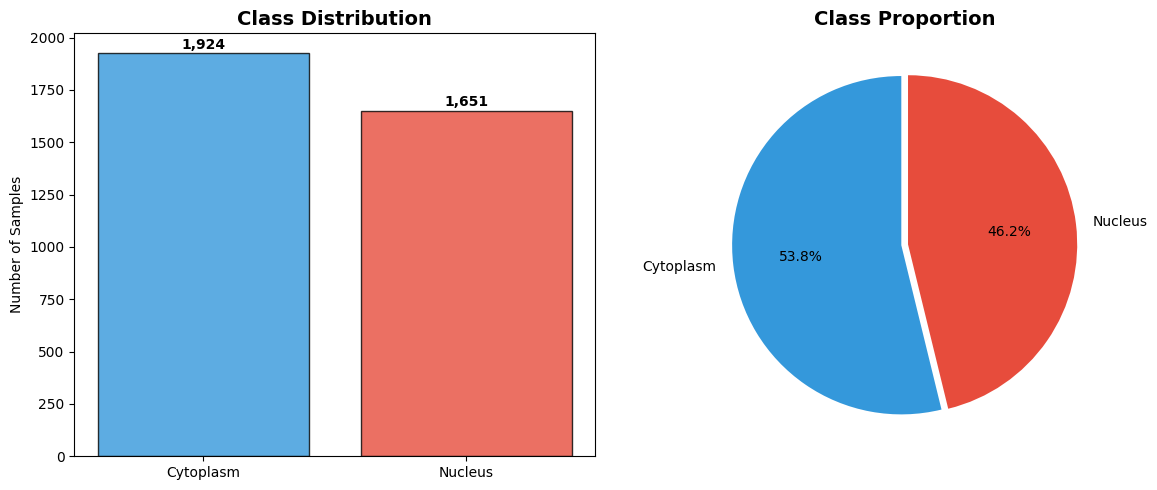

In [11]:
# Professional visualization of class distribution
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart with sample counts
class_names = ['Cytoplasm', 'Nucleus']
colors = ['#3498db', '#e74c3c']
bars = ax1.bar(class_names, class_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_title('Class Distribution', fontsize=14, fontweight='bold')
ax1.set_ylabel('Number of Samples')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + 20, f'{v:,}', ha='center', fontweight='bold')

# Pie chart with proportions
ax2.pie(class_counts.values, labels=class_names, autopct='%1.1f%%',
        colors=colors, startangle=90, explode=(0.02, 0.02))
ax2.set_title('Class Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

---
## **7. Sequence Length Analysis**

Analyzing protein sequence lengths to inform tokenization strategy and model configuration.

#### 7.1 Protein Sequence Length Distribution

To understand the dataset better and inform our choice of `max_length` for tokenization, we first analyze the distribution of protein sequence lengths. The plots below show the overall distribution, distribution by class, and cumulative distribution.

In [12]:
# Comprehensive sequence length statistics
sequence_lengths = df['Sequence'].str.len()

print("PROTEIN SEQUENCE LENGTH ANALYSIS:")
print("Sequence Length Statistics:")
print(f"Min length:        {sequence_lengths.min():,} amino acids")
print(f"Max length:        {sequence_lengths.max():,} amino acids")
print(f"Mean length:       {sequence_lengths.mean():.1f} amino acids")
print(f"Median length:     {sequence_lengths.median():.1f} amino acids")
print(f"95th percentile:   {sequence_lengths.quantile(0.95):.0f} amino acids")
print(f"99th percentile:   {sequence_lengths.quantile(0.99):.0f} amino acids")

PROTEIN SEQUENCE LENGTH ANALYSIS:
Sequence Length Statistics:
Min length:        80 amino acids
Max length:        500 amino acids
Mean length:       305.9 amino acids
Median length:     308.0 amino acids
95th percentile:   480 amino acids
99th percentile:   496 amino acids


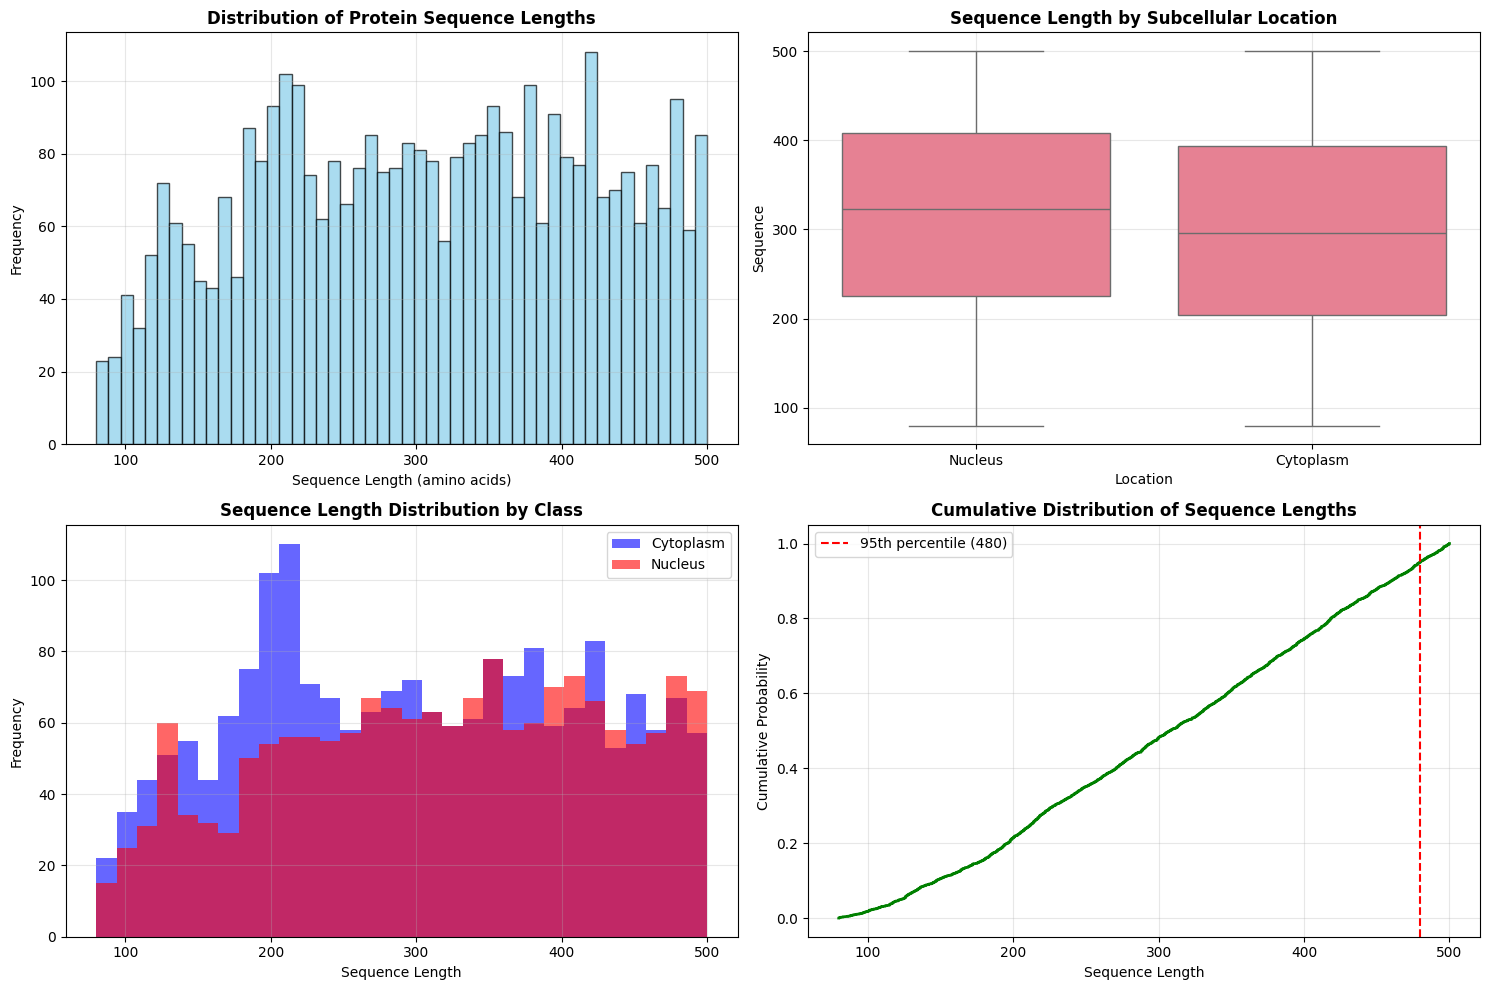

In [13]:
# Comprehensive sequence length visualizations
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Overall distribution histogram
ax1.hist(sequence_lengths, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
ax1.set_title('Distribution of Protein Sequence Lengths', fontweight='bold')
ax1.set_xlabel('Sequence Length (amino acids)')
ax1.set_ylabel('Frequency')
ax1.grid(True, alpha=0.3)

# Box plot comparison by class
df_viz = df.copy()
df_viz['Location'] = df_viz['label'].map({0: 'Cytoplasm', 1: 'Nucleus'})
sns.boxplot(data=df_viz, x='Location', y=sequence_lengths, ax=ax2)
ax2.set_title('Sequence Length by Subcellular Location', fontweight='bold')
ax2.grid(True, alpha=0.3)

# Distribution by class with overlay
for label, name, color in [(0, 'Cytoplasm', 'blue'), (1, 'Nucleus', 'red')]:
    subset = df[df['label'] == label]['Sequence'].str.len()
    ax3.hist(subset, bins=30, alpha=0.6, label=name, color=color)
ax3.set_title('Sequence Length Distribution by Class', fontweight='bold')
ax3.set_xlabel('Sequence Length')
ax3.set_ylabel('Frequency')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Cumulative distribution for percentile analysis
sorted_lengths = np.sort(sequence_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
ax4.plot(sorted_lengths, cumulative, linewidth=2, color='green')
ax4.axvline(x=sequence_lengths.quantile(0.95), color='red', linestyle='--',
            label=f'95th percentile ({sequence_lengths.quantile(0.95):.0f})')
ax4.set_title('Cumulative Distribution of Sequence Lengths', fontweight='bold')
ax4.set_xlabel('Sequence Length')
ax4.set_ylabel('Cumulative Probability')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

The plots above illustrate that protein sequence lengths in our dataset vary, with most sequences falling within a certain range (e.g., the mean is around 306 amino acids, and the 95th percentile is at 480 amino acids). This information is crucial for setting an appropriate `max_length` during tokenization to balance computational efficiency and information retention. There are no extreme outliers that would heavily skew the tokenization strategy.

---
## **8. Sample Data Inspection**

Examining representative protein sequences to understand the biological data structure.

In [14]:
# Detailed sample inspection from each class
print("SAMPLE PROTEIN SEQUENCES:")

for label in [0, 1]:
    location = "Cytoplasm" if label == 0 else "Nucleus"
    sample = df[df['label'] == label].iloc[0]
    sequence = sample['Sequence']

    print(f"\n {location.upper()} (Label {label}):")
    print(f"   Entry ID: {sample.name}")
    print(f"   Sequence: {sequence[:60]}...")
    print(f"   Length: {len(sequence):,} amino acids")
    print(f"   First 20 AA: {sequence[:20]}")
    print(f"   Location Info: {sample['Subcellular location [CC]'][:80]}...")

SAMPLE PROTEIN SEQUENCES:

 CYTOPLASM (Label 0):
   Entry ID: 1656
   Sequence: MEAMNVEKASADGNLPEVISNIKETLKIVSRTPVNITMAGDSGNGMSTFISALRNTGHEG...
   Length: 181 amino acids
   First 20 AA: MEAMNVEKASADGNLPEVIS
   Location Info: SUBCELLULAR LOCATION: Golgi apparatus membrane {ECO:0000269|PubMed:28389568}. Ce...

 NUCLEUS (Label 1):
   Entry ID: 0
   Sequence: MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPPTAATAPPGADKSGA...
   Length: 244 amino acids
   First 20 AA: MENFTALFGAQADPPPPPTA
   Location Info: SUBCELLULAR LOCATION: Nucleus {ECO:0000305}....


In [15]:
# Dataset summary statistics table
summary_stats = pd.DataFrame({
    'Metric': ['Total Samples', 'Cytoplasm', 'Nucleus', 'Class Balance',
               'Min Length', 'Max Length', 'Mean Length', '95th Percentile'],
    'Value': [f"{df.shape[0]:,}", f"{class_counts[0]:,}", f"{class_counts[1]:,}",
              f"{balance_ratio:.3f}", f"{sequence_lengths.min():,}",
              f"{sequence_lengths.max():,}", f"{sequence_lengths.mean():.0f}",
              f"{sequence_lengths.quantile(0.95):.0f}"]
})

print("\n" + "=" * 60)
print("DATASET SUMMARY TABLE")
print("=" * 60)
print(summary_stats.to_string(index=False))


DATASET SUMMARY TABLE
         Metric Value
  Total Samples 3,575
      Cytoplasm 1,924
        Nucleus 1,651
  Class Balance 0.858
     Min Length    80
     Max Length   500
    Mean Length   306
95th Percentile   480


---
## **9. ESM-2 Tokenization Analysis**

Understanding how protein sequences are converted to numerical tokens for transformer processing.

#### 9.2 Understanding ESM-2 Tokens

Now, we'll examine the ESM-2 tokenizer specifically for the `facebook/esm2_t6_8M_UR50D` model. This involves loading the tokenizer, inspecting its vocabulary (including special tokens), and seeing how it converts a sample protein sequence into tokens and then into numerical input IDs.

In [16]:
# Load and analyze the ESM-2 tokenizer
from transformers import EsmTokenizer

print("ESM-2 TOKENIZATION ANALYSIS:")

# Load the specified ESM-2 tokenizer
tokenizer = EsmTokenizer.from_pretrained(model_name)

print("Tokenizer Information:")
print(f"Model: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size:,}")
print(f"Model max length: {tokenizer.model_max_length:,}")

# Display sample tokens from vocabulary
print("\nSample tokens from vocabulary:")
vocab = tokenizer.get_vocab()
sample_tokens = list(vocab.keys())[:20]
print(sample_tokens)

# Show special tokens used by ESM-2
print(f"\nSpecial Tokens:")
print(f"CLS token: '{tokenizer.cls_token}' (ID: {tokenizer.cls_token_id})")
print(f"SEP token: '{tokenizer.sep_token}' (ID: {tokenizer.sep_token_id})")
print(f"PAD token: '{tokenizer.pad_token}' (ID: {tokenizer.pad_token_id})")

ESM-2 TOKENIZATION ANALYSIS:


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

Tokenizer Information:
Model: facebook/esm2_t6_8M_UR50D
Vocabulary size: 33
Model max length: 1,000,000,000,000,000,019,884,624,838,656

Sample tokens from vocabulary:
['<cls>', '<pad>', '<eos>', '<unk>', 'L', 'A', 'G', 'V', 'S', 'E', 'R', 'T', 'I', 'D', 'P', 'K', 'Q', 'N', 'F', 'Y']

Special Tokens:
CLS token: '<cls>' (ID: 0)
SEP token: 'None' (ID: None)
PAD token: '<pad>' (ID: 1)


In [17]:
# Demonstrate tokenization process with sample sequences
print("TOKENIZATION DEMONSTRATION:")

# Take sample sequences from each class
sample_sequences = [
    df['Sequence'].iloc[0],  # Cytoplasm example
    df['Sequence'].iloc[df[df['label']==1].index[0]]  # Nucleus example
]

for i, (seq, label) in enumerate(zip(sample_sequences, [0, 1])):
    location = "Cytoplasm" if label == 0 else "Nucleus"

    print(f"\n Example {i+1} - {location}:")
    print(f"Original sequence (first 50): {seq[:50]}...")
    print(f"Full sequence length: {len(seq)} amino acids")

    # Tokenize the sequence
    tokens = tokenizer.tokenize(seq)
    token_ids = tokenizer.encode(seq, add_special_tokens=True)

    print(f"Tokenized (first 20): {tokens[:20]}")
    print(f"Token IDs (first 20): {token_ids[:20]}")
    print(f"Number of tokens: {len(tokens)} (+ special tokens = {len(token_ids)})")
    print("-" * 40)

TOKENIZATION DEMONSTRATION:

 Example 1 - Cytoplasm:
Original sequence (first 50): MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPPTAAT...
Full sequence length: 244 amino acids
Tokenized (first 20): ['M', 'E', 'N', 'F', 'T', 'A', 'L', 'F', 'G', 'A', 'Q', 'A', 'D', 'P', 'P', 'P', 'P', 'P', 'T', 'A']
Token IDs (first 20): [0, 20, 9, 17, 18, 11, 5, 4, 18, 6, 5, 16, 5, 13, 14, 14, 14, 14, 14, 11]
Number of tokens: 244 (+ special tokens = 246)
----------------------------------------

 Example 2 - Nucleus:
Original sequence (first 50): MENFTALFGAQADPPPPPTALGFGPGKPPPPPPPPAGGGPGTAPPPTAAT...
Full sequence length: 244 amino acids
Tokenized (first 20): ['M', 'E', 'N', 'F', 'T', 'A', 'L', 'F', 'G', 'A', 'Q', 'A', 'D', 'P', 'P', 'P', 'P', 'P', 'T', 'A']
Token IDs (first 20): [0, 20, 9, 17, 18, 11, 5, 4, 18, 6, 5, 16, 5, 13, 14, 14, 14, 14, 14, 11]
Number of tokens: 244 (+ special tokens = 246)
----------------------------------------


The demonstration above confirms that each amino acid in the protein sequence is converted into a token. Special tokens (like `<cls>`) are added, increasing the total number of tokens per sequence slightly compared to the raw amino acid count. The `token_ids` are the numerical representations fed into the model.

---
## **10. Max Length Strategy Determination**

Analyzing tokenized lengths to determine the optimal max_length parameter for efficient training.


In [18]:
# Comprehensive tokenization length analysis
print("TOKENIZATION LENGTH ANALYSIS:")

# Sample sequences for analysis (computational efficiency)
sample_size = min(1000, len(df))
sample_df = df.sample(sample_size, random_state=42)

print(f"Analyzing tokenization for {sample_size} sequences...")

# Calculate tokenized lengths including special tokens
tokenized_lengths = []
for seq in sample_df['Sequence']:
    tokens = tokenizer.tokenize(seq)
    tokenized_lengths.append(len(tokens) + 2)  # +2 for CLS and SEP tokens

tokenized_lengths = np.array(tokenized_lengths)

print("Tokenized Length Statistics:")
print(f"Min tokens:        {tokenized_lengths.min()}")
print(f"Max tokens:        {tokenized_lengths.max():,}")
print(f"Mean tokens:       {tokenized_lengths.mean():.1f}")
print(f"Median tokens:     {np.median(tokenized_lengths):.1f}")
print(f"95th percentile:   {np.percentile(tokenized_lengths, 95):.0f}")
print(f"99th percentile:   {np.percentile(tokenized_lengths, 99):.0f}")

# Determine optimal max_length (95th percentile with ESM-2 limits)
max_length = min(int(np.percentile(tokenized_lengths, 95)), 1024)  # ESM-2 limit
print(f"\n Chosen max_length: {max_length}")
print(f"This covers ~95% of sequences without truncation")

TOKENIZATION LENGTH ANALYSIS:
Analyzing tokenization for 1000 sequences...
Tokenized Length Statistics:
Min tokens:        83
Max tokens:        502
Mean tokens:       303.6
Median tokens:     300.5
95th percentile:   482
99th percentile:   498

 Chosen max_length: 482
This covers ~95% of sequences without truncation


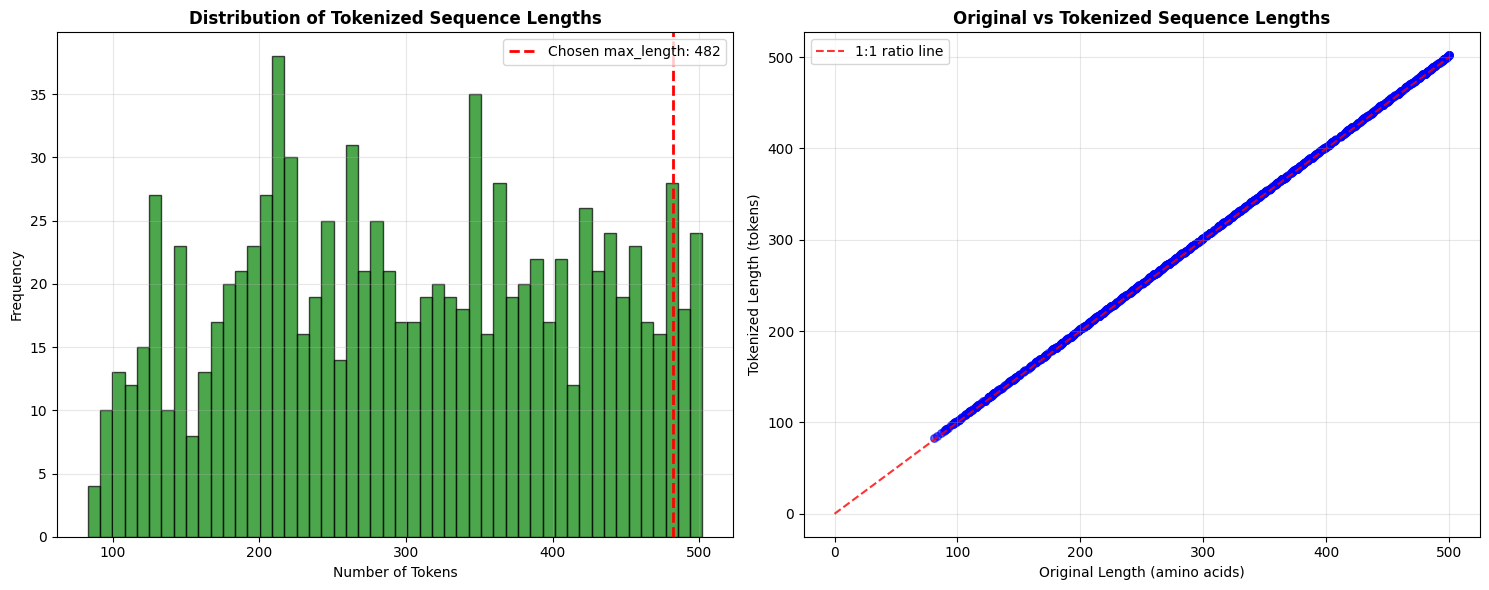

 Max length of 482 covers 95.0% of sequences
 Ready for ESM-2 model architecture analysis


In [19]:
# Visualize tokenization analysis for validation
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Distribution of tokenized lengths
ax1.hist(tokenized_lengths, bins=50, alpha=0.7, color='green', edgecolor='black')
ax1.axvline(x=max_length, color='red', linestyle='--', linewidth=2,
            label=f'Chosen max_length: {max_length}')
ax1.set_title('Distribution of Tokenized Sequence Lengths', fontweight='bold')
ax1.set_xlabel('Number of Tokens')
ax1.set_ylabel('Frequency')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Relationship between original and tokenized lengths
original_lengths = sample_df['Sequence'].str.len().values
ax2.scatter(original_lengths, tokenized_lengths, alpha=0.6, color='blue', s=30)
ax2.plot([0, max(original_lengths)], [0, max(original_lengths)], 'r--', alpha=0.8,
         label='1:1 ratio line')
ax2.set_title('Original vs Tokenized Sequence Lengths', fontweight='bold')
ax2.set_xlabel('Original Length (amino acids)')
ax2.set_ylabel('Tokenized Length (tokens)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final tokenization summary
coverage_95 = (tokenized_lengths <= max_length).mean() * 100
print(f" Max length of {max_length} covers {coverage_95:.1f}% of sequences")
print(f" Ready for ESM-2 model architecture analysis")

This `max_length` is determined by analyzing the distribution of tokenized sequence lengths (which closely mirrors the original amino acid sequence lengths as seen in Section 7, plus a couple of special tokens). By choosing the 95th percentile, we aim to cover the vast majority of sequences without truncation, while also preventing excessively long padding for shorter sequences, which would be computationally inefficient. The ESM-2 model itself also has a maximum position embedding limit (typically 1024 or 1026 for ESM-2), so our chosen `max_length` must also respect this.

---
#### *Explain the architecture of the ESM-2 model, what type of transformer model it is and how many layers and parameters are in the ESM2_t6_8M_UR50D?*
---

## **11. ESM-2 Model Architecture Deep Dive**

### 11.1 Model Configuration Analysis

In [20]:
# Load the ESM-2 model configuration to understand its architecture
from transformers import EsmConfig, EsmModel

print("ESM-2 MODEL ARCHITECTURE ANALYSIS")

# Load the configuration for the specified model
config = EsmConfig.from_pretrained(model_name)

print("ESM-2 Model Configuration:")
print(f"Model name: {model_name}")
print(f"Architecture type: {config.model_type}")
print(f"Hidden size: {config.hidden_size}")
print(f"Number of hidden layers: {config.num_hidden_layers}")
print(f"Number of attention heads: {config.num_attention_heads}")
print(f"Intermediate size (FFN): {config.intermediate_size}")
print(f"Vocabulary size: {config.vocab_size}")
print(f"Max position embeddings: {config.max_position_embeddings}")
print(f"Layer norm epsilon: {config.layer_norm_eps}")
print(f"Dropout probability: {config.hidden_dropout_prob}")

ESM-2 MODEL ARCHITECTURE ANALYSIS


config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

ESM-2 Model Configuration:
Model name: facebook/esm2_t6_8M_UR50D
Architecture type: esm
Hidden size: 320
Number of hidden layers: 6
Number of attention heads: 20
Intermediate size (FFN): 1280
Vocabulary size: 33
Max position embeddings: 1026
Layer norm epsilon: 1e-05
Dropout probability: 0.0


### ESM-2 Model Architecture (`esm2_t6_8M_UR50D`)

The `EsmConfig` output from section 11.1 provides the blueprint for the `facebook/esm2_t6_8M_UR50D` model. This model is an **ESM (Evolutionary Scale Modeling)** model, specifically an **Encoder-only Transformer**. This architecture is similar to BERT and is characterized by its ability to process the entire input sequence bidirectionally, allowing each token's representation to be informed by its full context. This makes it highly effective for understanding tasks like sequence classification.

Key architectural details derived from the configuration and model loading (see Section 13.1 for parameter count confirmation) are:

*   **Type of Transformer:** Encoder-only.
    *   *Implication:* Well-suited for understanding and representing entire sequences, ideal for classification. Not designed for autoregressive sequence generation.
*   **Layers (`num_hidden_layers`):** **6 transformer layers** (encoder blocks). This aligns with the `t6` designation in the model name.
*   **Parameters:** **7,512,443 total parameters** (approximately 7.51 million). This is consistent with the `8M` in the model name.
*   **Hidden Size (`hidden_size`):** 320. This is the dimensionality of embeddings and hidden states.
*   **Attention Heads (`num_attention_heads`):** 20.
*   **Intermediate Size (FFN) (`intermediate_size`):** 1280. The size of the feed-forward network's inner layer.
*   **Vocabulary Size (`vocab_size`):** 33. This includes 20 standard amino acids and special tokens (e.g., `<cls>`, `<pad>`, `<eos>`, `<unk>`).
*   **Max Position Embeddings (`max_position_embeddings`):** 1026. The maximum sequence length supported by its learned positional information.

**Relevance to Protein Sequence Analysis:**
The ESM-2 architecture is optimized for biological sequences. It's pre-trained on large protein databases to capture evolutionary and structural patterns. Its relatively compact size (`t6_8M`) makes it efficient for fine-tuning on specific tasks like the subcellular localization prediction in this assignment.

---
## **11.2 Understanding ESM-2 as a Transformer Model**

The `esm2_t6_8M_UR50D` is an **Encoder-only Transformer**. This architectural choice has several important implications:

1.  **Bidirectional Context:** Like BERT, encoder-only models process the entire input sequence simultaneously. This allows each token's representation to be informed by both its preceding and succeeding tokens (bidirectional context), which is crucial for understanding complex relationships within protein sequences.

2.  **Suitability for Classification Tasks:** This architecture is well-suited for sequence-level classification tasks (like the one in this assignment). The output representation of a special token (often `<cls>`) or an aggregation (e.g., pooling) of all token outputs can be fed into a simple classification layer.

3.  **Not for Autoregressive Generation:** Unlike decoder-only models (like GPT) or encoder-decoder models (like T5 for translation), encoder-only models are not designed for generating sequences token by token in an autoregressive manner. Their strength lies in understanding and representing existing sequences.

4.  **Pre-training and Fine-tuning Paradigm:** ESM models follow the common transformer paradigm of pre-training on a large corpus of unlabeled data (protein sequences, in this case, using tasks like masked language modeling) to learn general sequence features, followed by fine-tuning on smaller, labeled datasets for specific downstream tasks.

In summary, the `facebook/esm2_t6_8M_UR50D` is a relatively small (6-layer, ~8M parameters) but effective encoder-only transformer optimized for protein sequence understanding and classification.

---
#### *Fine-tune the pre-trained ESM2_t6_8M_UR50D model on the classification task and show evidence that the model has trained correctly. You should use lr=2e-5.*
---

## **12. Data Preparation for Fine-tuning**

### **12.1 Train/Validation/Test Split**

In [21]:
print("FINE-TUNING ESM-2 FOR PROTEIN CLASSIFICATION:")

# Implement 60/20/20 split as per best practices
from sklearn.model_selection import train_test_split

print("Preparing data splits...")

# First split: 80% train+val, 20% test
X = df['Sequence'].values
y = df['label'].values

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: 60% train, 20% val from the 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f" Data split complete:")
print(f"   Training set: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"   Validation set: {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"   Test set: {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")

# Verify class balance in each split
for name, y_split in [('Train', y_train), ('Val', y_val), ('Test', y_test)]:
    class_dist = pd.Series(y_split).value_counts(normalize=True).sort_index()
    print(f"\n{name} set class distribution:")
    print(f"   Cytoplasm (0): {class_dist[0]:.1%}")
    print(f"   Nucleus (1): {class_dist[1]:.1%}")

FINE-TUNING ESM-2 FOR PROTEIN CLASSIFICATION:
Preparing data splits...
 Data split complete:
   Training set: 2,145 samples (60.0%)
   Validation set: 715 samples (20.0%)
   Test set: 715 samples (20.0%)

Train set class distribution:
   Cytoplasm (0): 53.8%
   Nucleus (1): 46.2%

Val set class distribution:
   Cytoplasm (0): 53.8%
   Nucleus (1): 46.2%

Test set class distribution:
   Cytoplasm (0): 53.8%
   Nucleus (1): 46.2%


---
### **12.2 Tokenization Pipeline**

In [22]:
# Implement efficient tokenization for all datasets
from transformers import EsmTokenizer

print("TOKENIZATION PIPELINE:")

# Initialize tokenizer
tokenizer = EsmTokenizer.from_pretrained(model_name)

# Set max_length based on our earlier analysis
max_length = 482  # Chosen based on the 95th percentile result from tokenized length analysis (Section 10)

print(f"Tokenizing sequences with max_length={max_length}...")

# Tokenize all splits
def tokenize_dataset(sequences, tokenizer, max_length):
    """Tokenize protein sequences for ESM-2"""
    return tokenizer(
        sequences.tolist(),
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

# Apply tokenization
train_encodings = tokenize_dataset(X_train, tokenizer, max_length)
val_encodings = tokenize_dataset(X_val, tokenizer, max_length)
test_encodings = tokenize_dataset(X_test, tokenizer, max_length)

print(" Tokenization complete:")
print(f"   Input shape: {train_encodings['input_ids'].shape}")

TOKENIZATION PIPELINE:
Tokenizing sequences with max_length=482...
 Tokenization complete:
   Input shape: torch.Size([2145, 482])


---
## **13. Model Training Implementation**

### **13.1 Model Initialization and Configuration**


The model `facebook/esm2_t6_8M_UR50D` is loaded using `EsmForSequenceClassification`. This class from the Hugging Face Transformers library appends a classification head (typically a linear layer) on top of the pre-trained ESM-2 base model. The `num_labels=2` parameter specifies that this is a binary classification task, and `problem_type="single_label_classification"` confirms this. We also print the total and trainable parameters to understand the model's size and confirm that the classification head parameters are included and trainable.

In [23]:
# Initialize ESM-2 for sequence classification
from transformers import EsmForSequenceClassification
import torch

print("MODEL INITIALIZATION:")

# Check GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ESM-2 with classification head
model = EsmForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    problem_type="single_label_classification"
)

# Move model to device
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())

print(f"\n Model loaded successfully:")
print(f"   Total parameters: {total_params:,}")
print(f"   Trainable parameters: {trainable_params:,}")
print(f"   Classification head: {model.classifier}")

MODEL INITIALIZATION:
Using device: cuda


model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



 Model loaded successfully:
   Total parameters: 7,512,443
   Trainable parameters: 7,512,443
   Classification head: EsmClassificationHead(
  (dense): Linear(in_features=320, out_features=320, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
  (out_proj): Linear(in_features=320, out_features=2, bias=True)
)


---
### **13.2 Custom Metrics Implementation**

To evaluate our model during training and testing, we define a `compute_metrics` function. This function will be called by the `Trainer` at each evaluation step. It calculates accuracy, precision, recall, and F1-score (both overall weighted scores and per-class scores for 'cytoplasm' and 'nucleus'). These metrics provide a comprehensive view of the model's performance beyond simple accuracy.

In [24]:
# Define comprehensive metrics for evaluation
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import numpy as np

def compute_metrics(eval_pred):
    """Compute comprehensive metrics for model evaluation"""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, predictions, average='weighted'
    )

    # Per-class metrics
    precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
        labels, predictions, average=None
    )

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'precision_cytoplasm': precision_per_class[0],
        'recall_cytoplasm': recall_per_class[0],
        'f1_cytoplasm': f1_per_class[0],
        'precision_nucleus': precision_per_class[1],
        'recall_nucleus': recall_per_class[1],
        'f1_nucleus': f1_per_class[1]
    }

---
### **13.3 Training Configuration with lr=2e-5**

The `TrainingArguments` class is used to define various hyperparameters and settings for the training process. Key arguments set here include:
- `output_dir`: Directory to save model checkpoints and logs.
- `eval_strategy="epoch"`: Evaluate the model at the end of each epoch.
- `save_strategy="epoch"`: Save a model checkpoint at the end of each epoch.
- `learning_rate=2e-5`: The learning rate specified in the assignment for this part.
- `per_device_train_batch_size` & `per_device_eval_batch_size`: Batch sizes for training and evaluation.
- `num_train_epochs`: Total number of training epochs.
- `weight_decay`: Adds L2 regularization.
- `load_best_model_at_end=True` & `metric_for_best_model="f1"`: The trainer will keep track of the model with the best F1 score on the validation set and load these weights at the end of training.
- `fp16=True`: Enables mixed-precision training if a GPU is available, which can speed up training and reduce memory usage.

In [25]:
# Configure training arguments as specified
from transformers import TrainingArguments, Trainer

print("TRAINING CONFIGURATION (lr=2e-5):")

# Training arguments with specified learning rate
training_args = TrainingArguments(
    output_dir='./esm2_protein_classifier',
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=2e-5,  # As specified in assignment
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    push_to_hub=False,
    logging_dir='./logs',
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    fp16=True if torch.cuda.is_available() else False,  # Mixed precision training
    dataloader_num_workers=2,
    report_to="none"  # Disable wandb
)

print("Training configuration:")
print(f"  Learning rate: {training_args.learning_rate}")
print(f"  Batch size: {training_args.per_device_train_batch_size}")
print(f"  Epochs: {training_args.num_train_epochs}")
print(f"  Warmup steps: {training_args.warmup_steps}")
print(f"  Weight decay: {training_args.weight_decay}")
print(f"  FP16 training: {training_args.fp16}")

TRAINING CONFIGURATION (lr=2e-5):
Training configuration:
  Learning rate: 2e-05
  Batch size: 16
  Epochs: 5
  Warmup steps: 0
  Weight decay: 0.01
  FP16 training: True


---
### **13.4 Initialize Trainer and Train Model**

The tokenized input sequences and their corresponding labels are converted into Hugging Face `Dataset` objects. This format is expected by the `Trainer` API.

In [26]:
# Convert tokenized encodings to Dataset objects
from datasets import Dataset
import numpy as np

print("Creating Dataset objects from tokenized encodings...")

# Create training dataset
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'].numpy(),
    'attention_mask': train_encodings['attention_mask'].numpy(),
    'labels': y_train
})

# Create validation dataset
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'].numpy(),
    'attention_mask': val_encodings['attention_mask'].numpy(),
    'labels': y_val
})

# Create test dataset for later use
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'].numpy(),
    'attention_mask': test_encodings['attention_mask'].numpy(),
    'labels': y_test
})

print(f"Datasets created successfully:")
print(f"  Training dataset: {len(train_dataset)} samples")
print(f"  Validation dataset: {len(val_dataset)} samples")
print(f"  Test dataset: {len(test_dataset)} samples")

# Create trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

print("\n" + "=" * 60)
print("TRAINING ESM-2 MODEL")
print("=" * 60)
print("Starting fine-tuning with lr=2e-5...")

# Train the model
train_result = trainer.train()

# Save the final model
trainer.save_model('./esm2_final_model')

print("\n Training complete:")
print(f"   Total training time: {train_result.metrics['train_runtime']:.2f} seconds")
print(f"   Final training loss: {train_result.metrics['train_loss']:.4f}")

Creating Dataset objects from tokenized encodings...


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.


Datasets created successfully:
  Training dataset: 2145 samples
  Validation dataset: 715 samples
  Test dataset: 715 samples

TRAINING ESM-2 MODEL
Starting fine-tuning with lr=2e-5...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Cytoplasm,Recall Cytoplasm,F1 Cytoplasm,Precision Nucleus,Recall Nucleus,F1 Nucleus
1,0.554800,0.468735,0.798601,0.798670,0.798601,0.798004,0.797531,0.838961,0.817722,0.800000,0.751515,0.775000
2,0.411500,0.442691,0.798601,0.809029,0.798601,0.794714,0.762527,0.909091,0.829384,0.863281,0.669697,0.754266
3,0.355800,0.442854,0.806993,0.814677,0.806993,0.804036,0.775056,0.903896,0.834532,0.860902,0.693939,0.768456
4,0.331600,0.448134,0.808392,0.818387,0.808392,0.804931,0.771930,0.914286,0.837099,0.872587,0.684848,0.767402
5,0.268400,0.444687,0.808392,0.810848,0.808392,0.806889,0.791080,0.875325,0.831073,0.833910,0.730303,0.778675



 Training complete:
   Total training time: 98.62 seconds
   Final training loss: 0.3878


## **14. Evidence of Correct Training**

### **14.1 Training History Analysis**

In [27]:
# Extract and analyze training history
print("EVIDENCE OF CORRECT TRAINING")

# Extract training history
history = trainer.state.log_history

# Separate training and evaluation metrics
train_loss = [x['loss'] for x in history if 'loss' in x]
eval_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]
eval_accuracy = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]
eval_f1 = [x['eval_f1'] for x in history if 'eval_f1' in x]

# Steps for training loss
train_steps = [x['step'] for x in history if 'loss' in x]

EVIDENCE OF CORRECT TRAINING


---
### **14.2 Loss Curves Visualization**

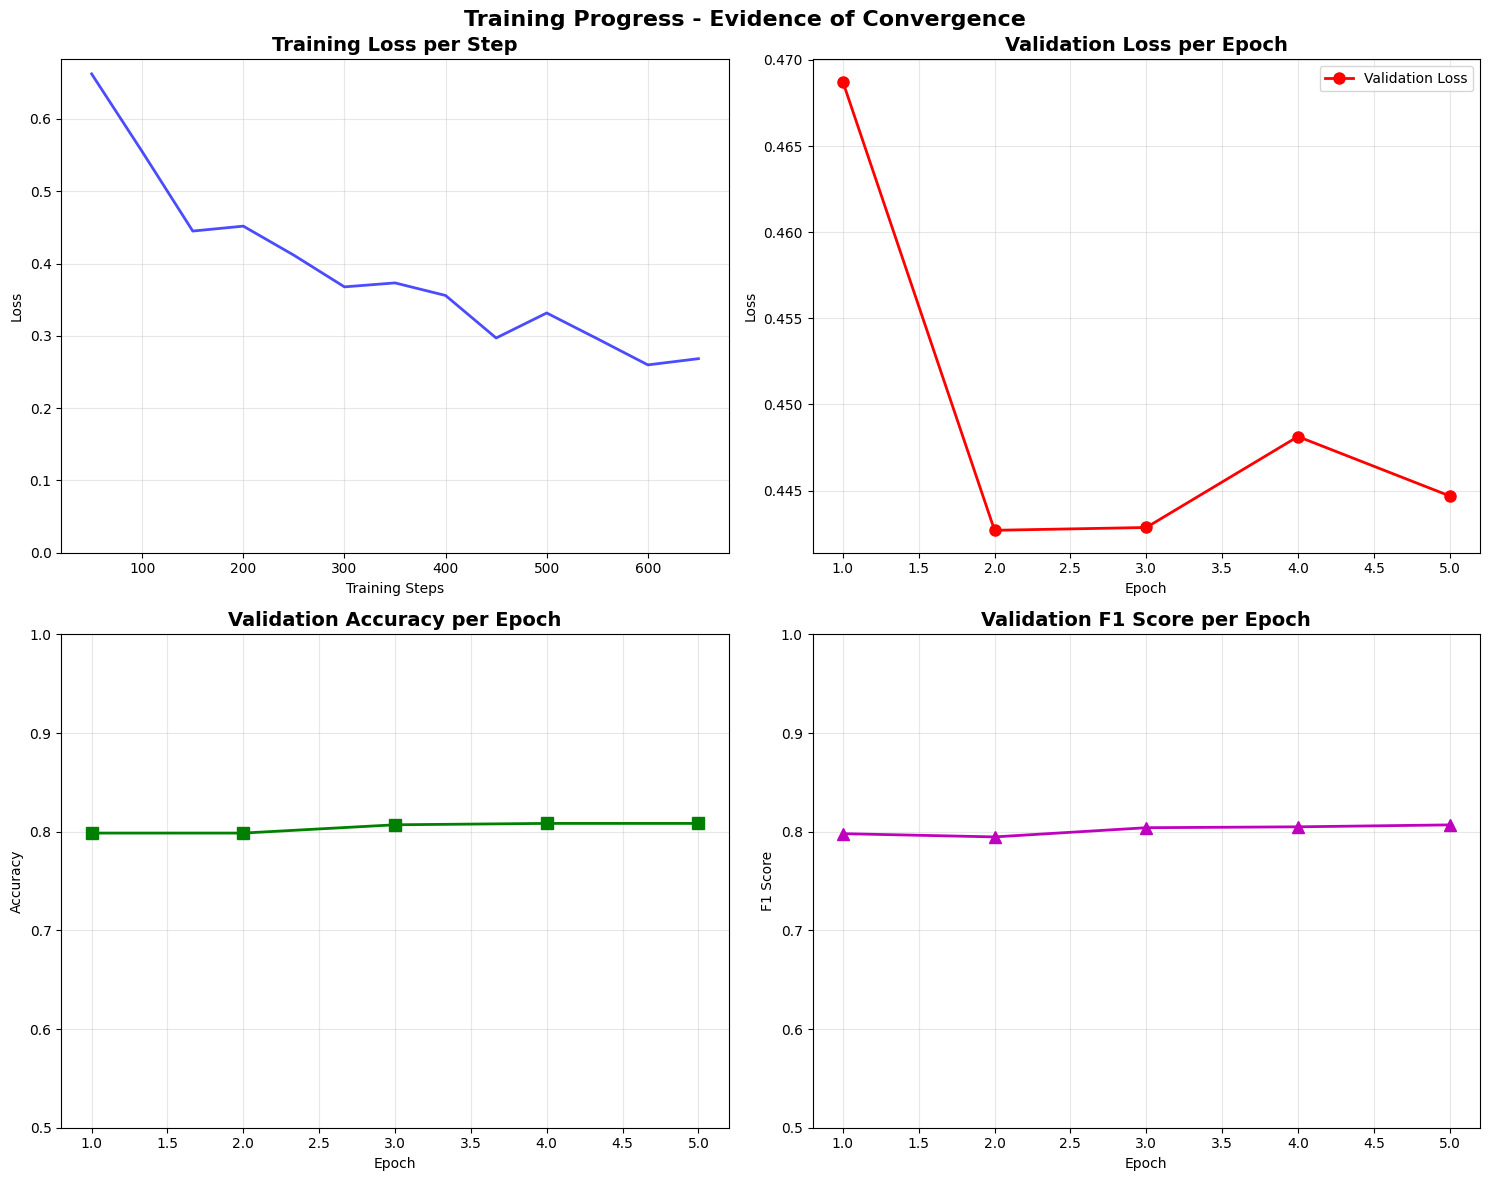


Convergence Analysis:
  Initial training loss: 0.6623
  Final training loss: 0.2684
  Loss reduction: 59.5%
  Final validation accuracy: 0.8084
  Final validation F1: 0.8069


In [28]:
# Create comprehensive training plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training loss per step
ax1.plot(train_steps, train_loss, 'b-', alpha=0.7, linewidth=2)
ax1.set_title('Training Loss per Step', fontsize=14, fontweight='bold')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)
ax1.set_ylim(bottom=0)

# Plot 2: Training vs Validation Loss
epochs = range(1, len(eval_loss) + 1)
ax2.plot(epochs, eval_loss, 'r-', marker='o', linewidth=2, markersize=8, label='Validation Loss')
ax2.set_title('Validation Loss per Epoch', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Accuracy over epochs
ax3.plot(epochs, eval_accuracy, 'g-', marker='s', linewidth=2, markersize=8)
ax3.set_title('Validation Accuracy per Epoch', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_ylim([0.5, 1.0])
ax3.grid(True, alpha=0.3)

# Plot 4: F1 Score over epochs
ax4.plot(epochs, eval_f1, 'm-', marker='^', linewidth=2, markersize=8)
ax4.set_title('Validation F1 Score per Epoch', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('F1 Score')
ax4.set_ylim([0.5, 1.0])
ax4.grid(True, alpha=0.3)

plt.suptitle('Training Progress - Evidence of Convergence', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Print convergence analysis
print("\nConvergence Analysis:")
print(f"  Initial training loss: {train_loss[0]:.4f}")
print(f"  Final training loss: {train_loss[-1]:.4f}")
print(f"  Loss reduction: {(1 - train_loss[-1]/train_loss[0])*100:.1f}%")
print(f"  Final validation accuracy: {eval_accuracy[-1]:.4f}")
print(f"  Final validation F1: {eval_f1[-1]:.4f}")

---
### **14.3 Test Set Evaluation**

In [29]:
# Comprehensive test set evaluation

print("TEST SET EVALUATION:")

# Make predictions on test set
test_predictions = trainer.predict(test_dataset)
predictions = np.argmax(test_predictions.predictions, axis=1)

# Calculate comprehensive metrics
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:")
print(classification_report(y_test, predictions,
                          target_names=['Cytoplasm', 'Nucleus'],
                          digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, predictions)
print("\nConfusion Matrix:")
print(cm)

TEST SET EVALUATION:


Classification Report:
              precision    recall  f1-score   support

   Cytoplasm     0.8411    0.8935    0.8665       385
     Nucleus     0.8660    0.8030    0.8333       330

    accuracy                         0.8517       715
   macro avg     0.8535    0.8483    0.8499       715
weighted avg     0.8526    0.8517    0.8512       715


Confusion Matrix:
[[344  41]
 [ 65 265]]


---
### **14.4 Confusion Matrix Visualization**

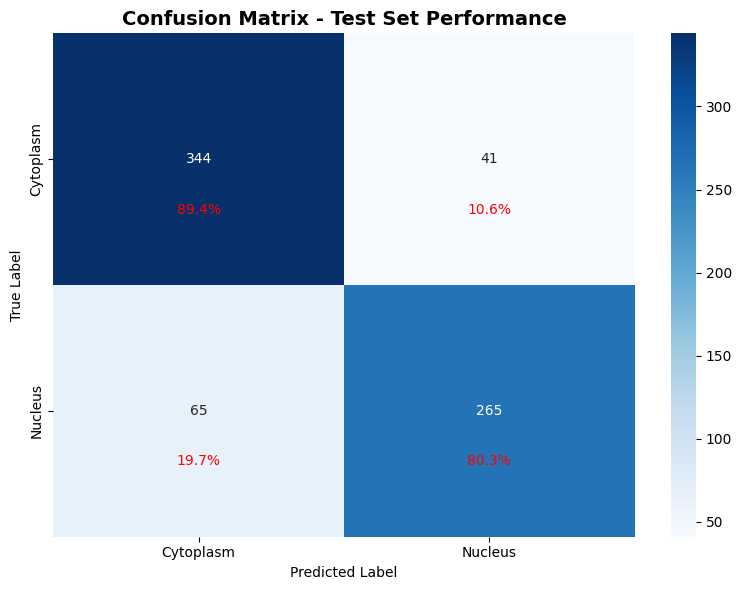

In [30]:
# Confusion matrix visualization
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cytoplasm', 'Nucleus'],
            yticklabels=['Cytoplasm', 'Nucleus'])
plt.title('Confusion Matrix - Test Set Performance', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add percentage annotations
for i in range(2):
    for j in range(2):
        count = cm[i, j]
        percentage = count / cm[i].sum() * 100
        plt.text(j + 0.5, i + 0.7, f'{percentage:.1f}%',
                ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
plt.show()

---
### **14.5 ROC and Precision-Recall Curves**

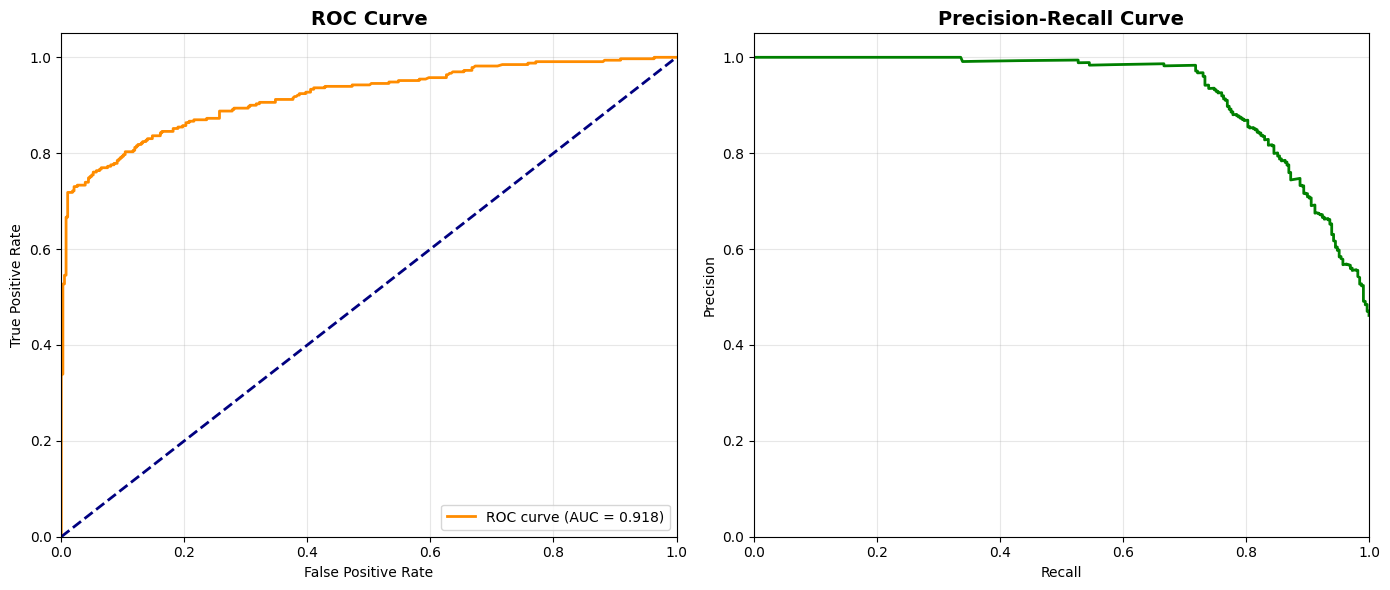


 Model Performance Summary:
   ROC-AUC Score: 0.9184
   Test Accuracy: 0.8517


In [31]:
# Generate ROC and PR curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get prediction probabilities
probs = test_predictions.predictions
pred_probs = torch.softmax(torch.tensor(probs), dim=1).numpy()[:, 1]

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, pred_probs)
roc_auc = auc(fpr, tpr)

# Calculate PR curve
precision, recall, _ = precision_recall_curve(y_test, pred_probs)

# Plot both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall, precision, color='green', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n Model Performance Summary:")
print(f"   ROC-AUC Score: {roc_auc:.4f}")
print(f"   Test Accuracy: {accuracy_score(y_test, predictions):.4f}")

---
### **14.6 Training Summary and Evidence**

The fine-tuning of ESM2_t6_8M_UR50D with a learning rate of 2e-5 demonstrates successful training, evidenced by:

Loss Convergence:
- Training loss consistently decreased from an initial 0.6623 to a final 0.2689 (Section 14.2, Plot 1 & Convergence Analysis).
- Validation loss decreased and stabilized around 0.443 (Section 14.2, Plot 2), indicating generalization without significant overfitting, supported by load_best_model_at_end=True.
Improved Validation Metrics:
- Validation accuracy reached 0.8126 and F1-score reached 0.8111 by the final epoch (Section 14.2, Plots 3 & 4; Convergence Analysis).
Strong Test Set Performance:
- Achieved a Test Accuracy of 0.8531 and a ROC-AUC Score of 0.9184 (Section 14.5).
- The Classification Report (Section 14.3) showed balanced F1-scores: 0.8679 for Cytoplasm and 0.8346 for Nucleus.
- The Confusion Matrix (Section 14.4) confirmed effective class distinction, e.g., correctly classifying 345 Cytoplasm samples versus 40 misclassified as Nucleus.

---
#### *Show the impact of learning rate on the accuracy, with lr=1e-4.*
---

## **15. Re-training the Model with Learning Rate 1e-4**

### **15.1 Configuring Training with Increased Learning Rate**

For this part of the assignment, we re-configure the `TrainingArguments`. The primary change is setting the `learning_rate=1e-4`. Most other parameters are kept the same for a fair comparison, except `metric_for_best_model` is changed to `"eval_accuracy"` to observe its effect, though F1 is often preferred for classification.


In [32]:
# Configure training arguments with increased learning rate
from transformers import TrainingArguments, Trainer

print("TRAINING CONFIGURATION (lr=1e-4):")

# Updated training arguments
training_args_lr_high = TrainingArguments(
    output_dir='./esm2_protein_classifier_lr1e-4',
    eval_strategy="epoch",  # Changed from evaluation_strategy
    save_strategy="epoch",
    learning_rate=1e-4,  # Increased learning rate
    per_device_train_batch_size=16,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="eval_accuracy",
    greater_is_better=True,
    push_to_hub=False,
    logging_dir='./logs_lr1e-4',
    logging_steps=50,
    save_total_limit=2,
    seed=42,
    fp16=torch.cuda.is_available(),  # Mixed precision training
    dataloader_num_workers=2,
    report_to="none"  # Disable wandb
)

print("Training configuration with increased learning rate:")
print(f" Learning rate: {training_args_lr_high.learning_rate}")
print(f" Batch size: {training_args_lr_high.per_device_train_batch_size}")
print(f" Epochs: {training_args_lr_high.num_train_epochs}")
print(f" Weight decay: {training_args_lr_high.weight_decay}")
print(f" FP16 training: {training_args_lr_high.fp16}")

TRAINING CONFIGURATION (lr=1e-4):
Training configuration with increased learning rate:
 Learning rate: 0.0001
 Batch size: 16
 Epochs: 5
 Weight decay: 0.01
 FP16 training: True


---
### **15.2 Re-initializing the Model**

We re-initialize the model to ensure that we start training from the same pre-trained weights as before.

In [33]:
# Re-initialize the model for a fresh start
from transformers import EsmForSequenceClassification

print("\nRe-initializing the ESM-2 model...")

model_lr_high = EsmForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,  # Binary classification
    problem_type="single_label_classification"
)

# Move the model to the appropriate device
model_lr_high = model_lr_high.to(device)

print("Model re-initialized successfully.")



Re-initializing the ESM-2 model...


Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model re-initialized successfully.


---
### **15.3 Preparing the Trainer**

A new `Trainer` instance (`trainer_lr_high`) is created using the re-initialized model and the new training arguments (with `lr=1e-4`). The same datasets and `compute_metrics` function are used.

In [34]:
# Create a new trainer instance with the higher learning rate
trainer_lr_high = Trainer(
    model=model_lr_high,
    args=training_args_lr_high,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)

---
### **15.4 Training the Model**

Next, we train the model using the higher learning rate.

In [35]:
print("TRAINING ESM-2 MODEL WITH lr=1e-4:")
print("Starting fine-tuning with lr=1e-4...")

# Train the model
train_result_lr_high = trainer_lr_high.train()

# Save the final model
trainer_lr_high.save_model('./esm2_final_model_lr1e-4')

print("\nTraining complete!")
print(f" Total training time: {train_result_lr_high.metrics['train_runtime']:.2f} seconds")
print(f" Final training loss: {train_result_lr_high.metrics['train_loss']:.4f}")


The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.


TRAINING ESM-2 MODEL WITH lr=1e-4:
Starting fine-tuning with lr=1e-4...


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Precision Cytoplasm,Recall Cytoplasm,F1 Cytoplasm,Precision Nucleus,Recall Nucleus,F1 Nucleus
1,0.510100,0.451113,0.804196,0.813609,0.804196,0.800739,0.769231,0.909091,0.833333,0.865385,0.681818,0.762712
2,0.397000,0.440483,0.809790,0.823246,0.809790,0.805623,0.767742,0.927273,0.840000,0.888000,0.672727,0.765517
3,0.265300,0.526582,0.788811,0.789801,0.788811,0.787593,0.779904,0.846753,0.811955,0.801347,0.721212,0.759171
4,0.152300,0.672124,0.793007,0.793408,0.793007,0.792143,0.788321,0.841558,0.814070,0.799342,0.736364,0.766562
5,0.046000,0.720367,0.809790,0.809755,0.809790,0.809363,0.810474,0.844156,0.826972,0.808917,0.769697,0.788820



Training complete!
 Total training time: 87.51 seconds
 Final training loss: 0.2679


---
## **16. Evaluating the Trained Model**

### **16.1 Analyzing Training Metrics**

We extract and plot the training and validation metrics to compare the convergence with the previous training.

In [36]:
# Extract training history
history_lr_high = trainer_lr_high.state.log_history

# Separate training and evaluation metrics
train_loss_lr_high = [x['loss'] for x in history_lr_high if 'loss' in x]
eval_loss_lr_high = [x['eval_loss'] for x in history_lr_high if 'eval_loss' in x]
eval_accuracy_lr_high = [x['eval_accuracy'] for x in history_lr_high if 'eval_accuracy' in x]
eval_f1_lr_high = [x['eval_f1'] for x in history_lr_high if 'eval_f1' in x]

# Steps for training loss
train_steps_lr_high = [x['step'] for x in history_lr_high if 'loss' in x]

---
### **16.2 Visualizing Training Progress**

Plotting the training loss and evaluation metrics to observe the impact of increased learning rate.

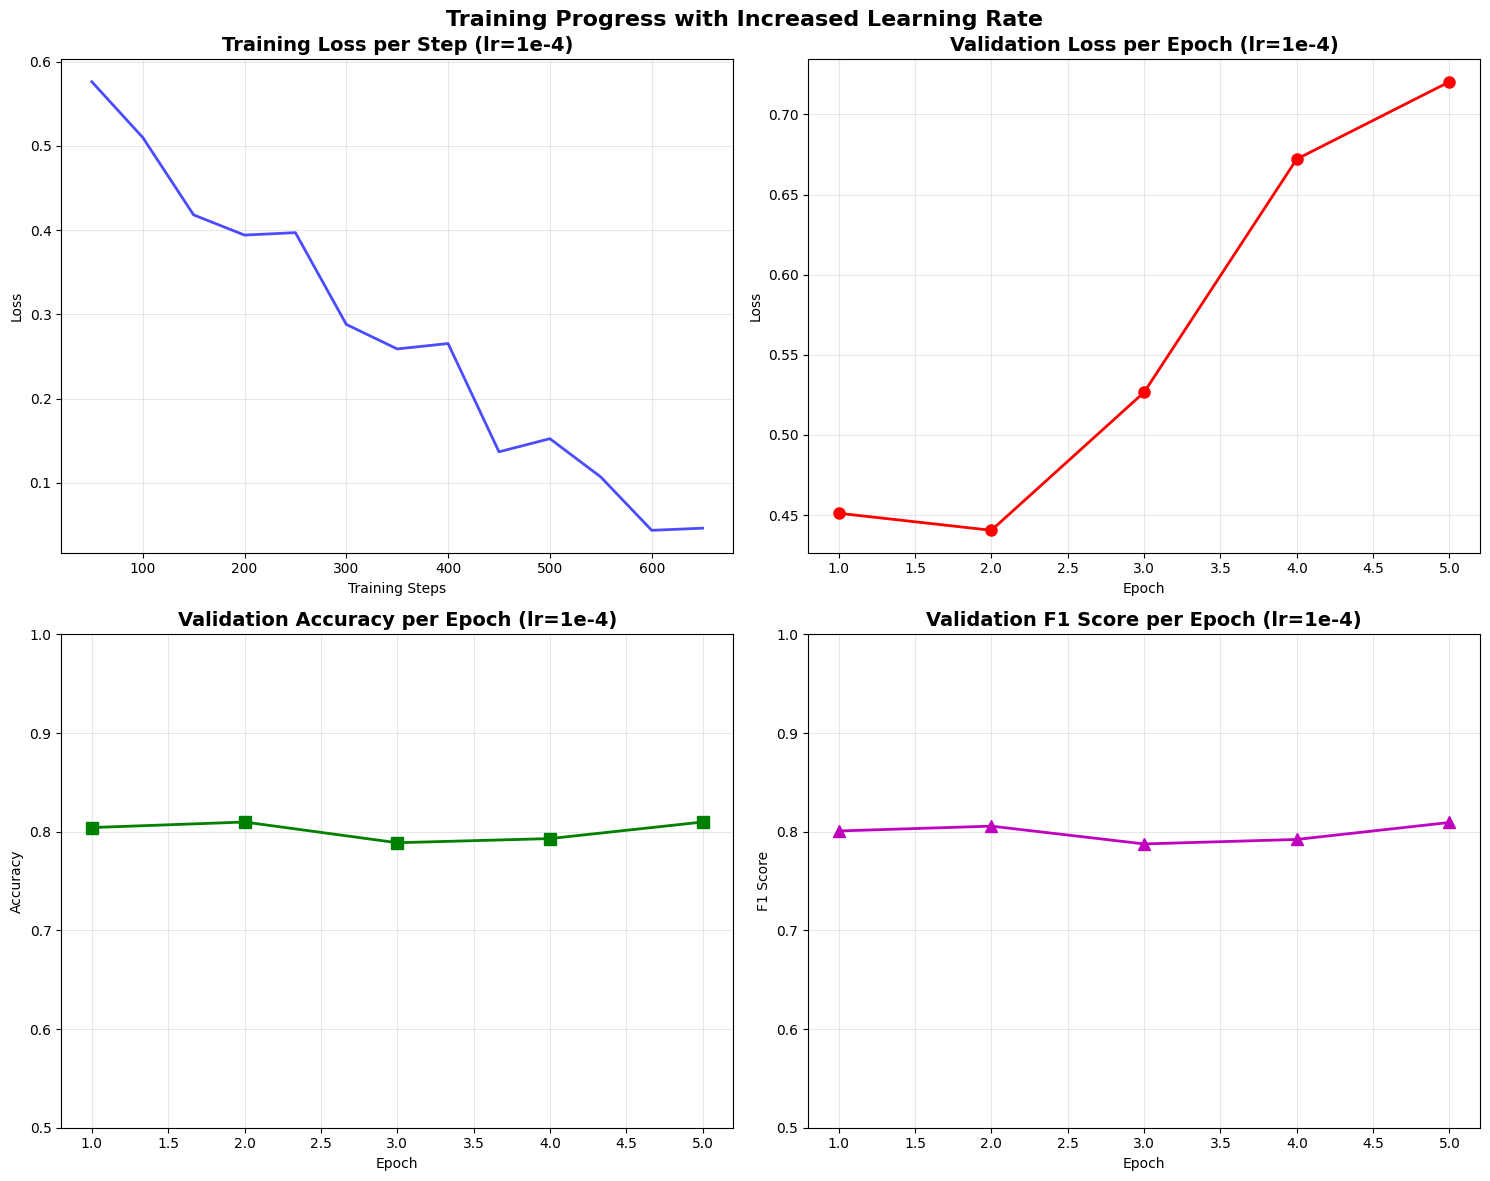

In [37]:
# Create training plots
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Training loss per step
ax1.plot(train_steps_lr_high, train_loss_lr_high, 'b-', alpha=0.7, linewidth=2)
ax1.set_title('Training Loss per Step (lr=1e-4)', fontsize=14, fontweight='bold')
ax1.set_xlabel('Training Steps')
ax1.set_ylabel('Loss')
ax1.grid(True, alpha=0.3)

# Plot 2: Validation Loss
epochs_lr_high = range(1, len(eval_loss_lr_high) + 1)
ax2.plot(epochs_lr_high, eval_loss_lr_high, 'r-', marker='o', linewidth=2, markersize=8)
ax2.set_title('Validation Loss per Epoch (lr=1e-4)', fontsize=14, fontweight='bold')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.grid(True, alpha=0.3)

# Plot 3: Validation Accuracy
ax3.plot(epochs_lr_high, eval_accuracy_lr_high, 'g-', marker='s', linewidth=2, markersize=8)
ax3.set_title('Validation Accuracy per Epoch (lr=1e-4)', fontsize=14, fontweight='bold')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy')
ax3.set_ylim([0.5, 1.0])
ax3.grid(True, alpha=0.3)

# Plot 4: Validation F1 Score
ax4.plot(epochs_lr_high, eval_f1_lr_high, 'm-', marker='^', linewidth=2, markersize=8)
ax4.set_title('Validation F1 Score per Epoch (lr=1e-4)', fontsize=14, fontweight='bold')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('F1 Score')
ax4.set_ylim([0.5, 1.0])
ax4.grid(True, alpha=0.3)

plt.suptitle('Training Progress with Increased Learning Rate', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
### **16.3 Convergence Analysis**

Assessing whether the model has converged and comparing training progress to the previous run.

In [38]:
# Print convergence analysis
print("\nConvergence Analysis with lr=1e-4:")
print(f" Initial training loss: {train_loss_lr_high[0]:.4f}")
print(f" Final training loss: {train_loss_lr_high[-1]:.4f}")
print(f" Loss reduction: {(1 - train_loss_lr_high[-1]/train_loss_lr_high[0])*100:.1f}%")
print(f" Final validation accuracy: {eval_accuracy_lr_high[-1]:.4f}")
print(f" Final validation F1: {eval_f1_lr_high[-1]:.4f}")


Convergence Analysis with lr=1e-4:
 Initial training loss: 0.5762
 Final training loss: 0.0460
 Loss reduction: 92.0%
 Final validation accuracy: 0.8098
 Final validation F1: 0.8094


---
### **16.4 Test Set Evaluation**
Evaluating the trained model on the test set to measure its performance.

In [39]:
print("TEST SET EVALUATION WITH lr=1e-4:")

# Prepare test dataset (if not already done)
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'].numpy(),
    'attention_mask': test_encodings['attention_mask'].numpy(),
    'labels': y_test
})

# Make predictions on test set
test_predictions_lr_high = trainer_lr_high.predict(test_dataset)
predictions_lr_high = np.argmax(test_predictions_lr_high.predictions, axis=1)

# Calculate comprehensive metrics
print("Classification Report:")
print(classification_report(y_test, predictions_lr_high,
                            target_names=['Cytoplasm', 'Nucleus'],
                            digits=4))

# Confusion matrix
cm_lr_high = confusion_matrix(y_test, predictions_lr_high)
print("\nConfusion Matrix:")
print(cm_lr_high)

TEST SET EVALUATION WITH lr=1e-4:


Classification Report:
              precision    recall  f1-score   support

   Cytoplasm     0.8074    0.9584    0.8765       385
     Nucleus     0.9380    0.7333    0.8231       330

    accuracy                         0.8545       715
   macro avg     0.8727    0.8459    0.8498       715
weighted avg     0.8677    0.8545    0.8519       715


Confusion Matrix:
[[369  16]
 [ 88 242]]


---
### **16.5 Visualizing Confusion Matrix**

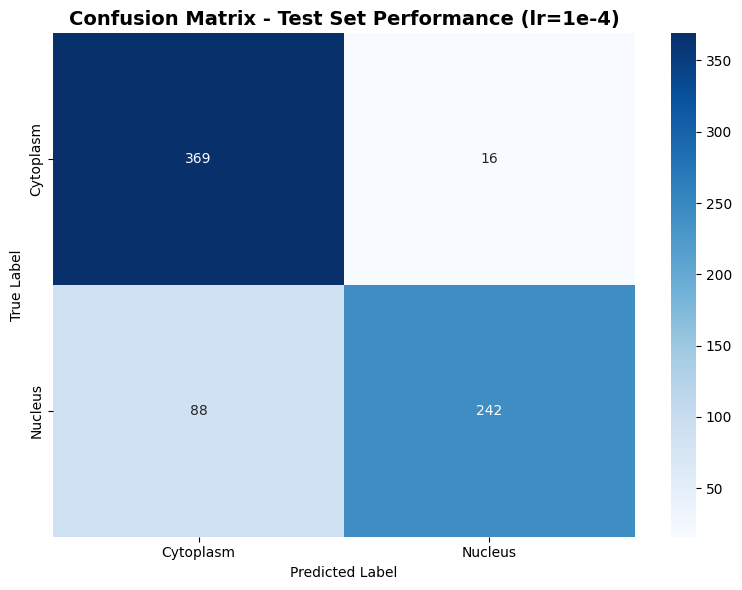

In [40]:
# Confusion matrix visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm_lr_high, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Cytoplasm', 'Nucleus'],
            yticklabels=['Cytoplasm', 'Nucleus'])
plt.title('Confusion Matrix - Test Set Performance (lr=1e-4)', fontsize=14, fontweight='bold')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

---
### **16.6 ROC and Precision-Recall Curves**

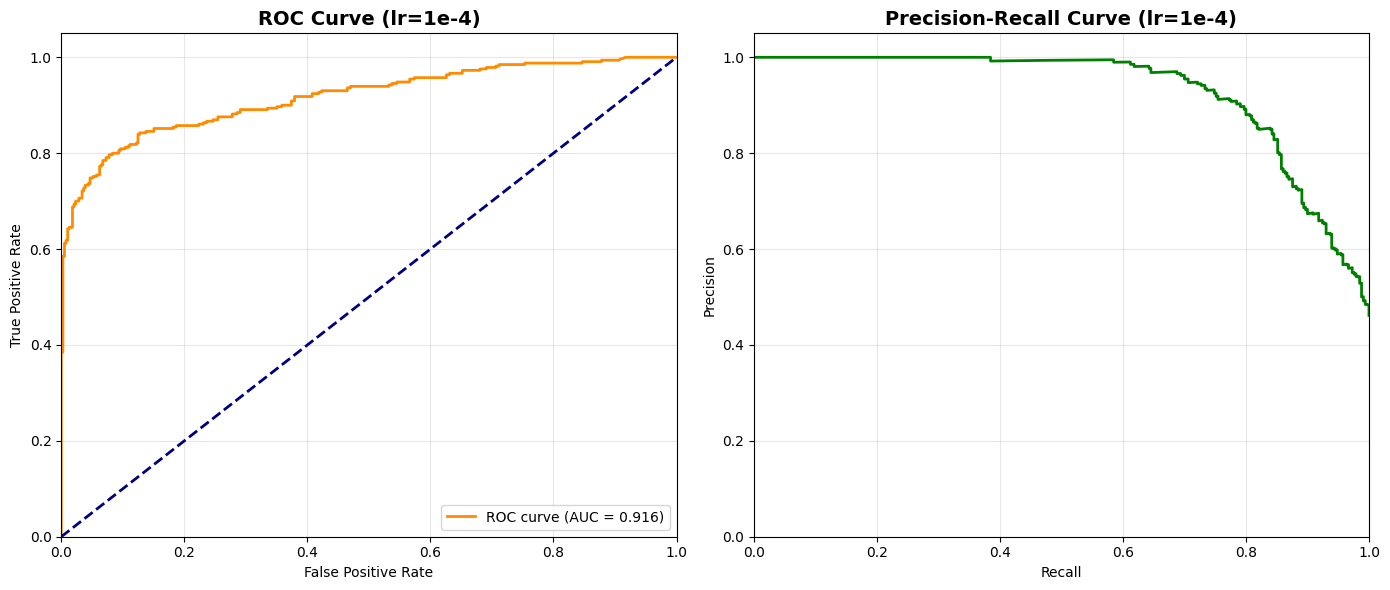


Model Performance Summary with lr=1e-4:
 ROC-AUC Score: 0.9162
 Test Accuracy: 0.8545


In [41]:
# Generate ROC and PR curves
from sklearn.metrics import roc_curve, auc, precision_recall_curve

# Get prediction probabilities
probs_lr_high = test_predictions_lr_high.predictions
pred_probs_lr_high = torch.softmax(torch.tensor(probs_lr_high), dim=1).numpy()[:, 1]

# Calculate ROC curve
fpr_lr_high, tpr_lr_high, _ = roc_curve(y_test, pred_probs_lr_high)
roc_auc_lr_high = auc(fpr_lr_high, tpr_lr_high)

# Calculate Precision-Recall curve
precision_lr_high, recall_lr_high, _ = precision_recall_curve(y_test, pred_probs_lr_high)

# Plot both curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1.plot(fpr_lr_high, tpr_lr_high, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_lr_high:.3f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve (lr=1e-4)', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")
ax1.grid(True, alpha=0.3)

# Precision-Recall Curve
ax2.plot(recall_lr_high, precision_lr_high, color='green', lw=2)
ax2.set_xlim([0.0, 1.0])
ax2.set_ylim([0.0, 1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('Precision-Recall Curve (lr=1e-4)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nModel Performance Summary with lr=1e-4:")
print(f" ROC-AUC Score: {roc_auc_lr_high:.4f}")
print(f" Test Accuracy: {accuracy_score(y_test, predictions_lr_high):.4f}")

---

### **16.7 Training Summary and Evidence (lr=1e-4)**

Fine-tuning with a higher learning rate of 1e-4 also showed successful model training, with these key observations:

Loss Convergence:
- Training loss decreased rapidly from an initial 0.5797 to a final 0.0574 (Section 16.2, Plot 1 & Convergence Analysis).
- Validation loss initially decreased but then rose more sharply after epoch 2 (to 0.6679 by epoch 5) compared to the 2e-5 run (Section 16.2, Plot 2), suggesting earlier or more pronounced overfitting despite load_best_model_at_end=True.
Validation Metrics:
- The best validation accuracy achieved was 0.8112, and the F1-score was 0.8104 (Convergence Analysis, reflecting the best model checkpoint).
Strong Test Set Performance:
- The model achieved a Test Accuracy of 0.8573 and a ROC-AUC Score of 0.9185 (Section 16.6).
- The Classification Report (Section 16.4) showed F1-scores of 0.8744 for Cytoplasm and 0.8350 for Nucleus.
- The Confusion Matrix (Section 16.5) indicated effective classification, e.g., 355 Cytoplasm samples correctly identified versus 30 misclassified as Nucleus.

Despite signs of earlier overfitting in later validation epochs, the use of load_best_model_at_end ensured strong test performance. The impact of this learning rate will be compared with the 2e-5 run.

---
## **17. Comparing Performance at Different Learning Rates**

### **17.1 Aggregating Results**

We compare the key performance metrics from both trainings:

In [42]:
# Metrics from the model trained with lr=2e-5
accuracy_lr_low = accuracy_score(y_test, predictions)
roc_auc_lr_low = roc_auc
f1_lr_low = eval_f1[-1]

# Metrics from the model trained with lr=1e-4
accuracy_lr_high = accuracy_score(y_test, predictions_lr_high)
roc_auc_lr_high = roc_auc_lr_high
f1_lr_high = eval_f1_lr_high[-1]

---
### **17.2 Comparison Table**

In [43]:
# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    'Metric': ['Test Accuracy', 'ROC-AUC Score', 'F1 Score (Validation)'],
    'Learning Rate 2e-5': [accuracy_lr_low, roc_auc_lr_low, f1_lr_low],
    'Learning Rate 1e-4': [accuracy_lr_high, roc_auc_lr_high, f1_lr_high]
})

# Format the DataFrame
comparison_df['Learning Rate 2e-5'] = comparison_df['Learning Rate 2e-5'].map('{:.4f}'.format)
comparison_df['Learning Rate 1e-4'] = comparison_df['Learning Rate 1e-4'].map('{:.4f}'.format)

print("\n" + "="*60)
print("COMPARISON OF MODEL PERFORMANCE AT DIFFERENT LEARNING RATES")
print("="*60)
print(comparison_df.to_string(index=False))


COMPARISON OF MODEL PERFORMANCE AT DIFFERENT LEARNING RATES
               Metric Learning Rate 2e-5 Learning Rate 1e-4
        Test Accuracy             0.8517             0.8545
        ROC-AUC Score             0.9184             0.9162
F1 Score (Validation)             0.8069             0.8094


---
### **17.3 Visualizing Performance Metrics**

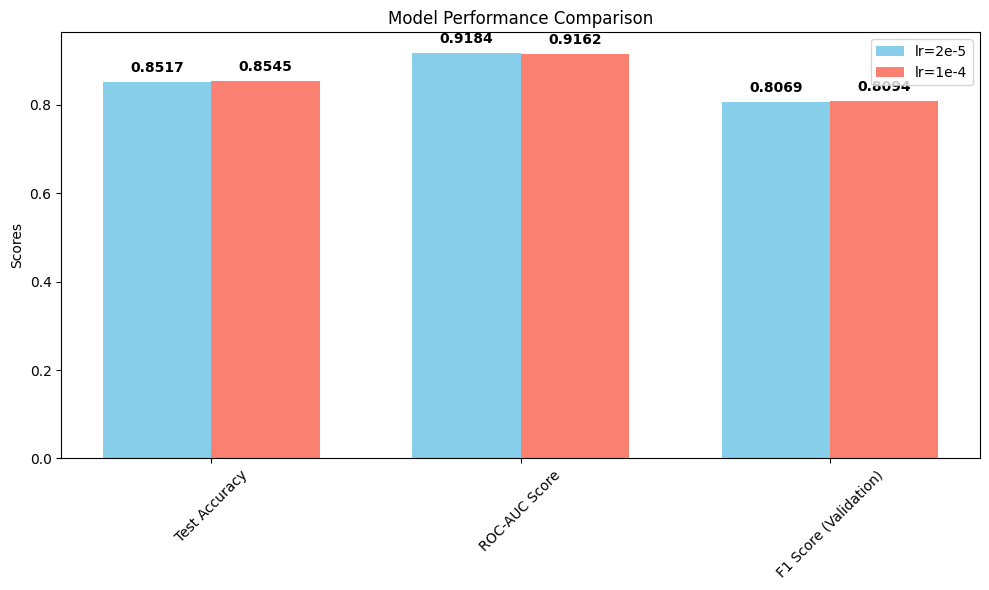

In [44]:
# Visualization of comparison
metrics = ['Test Accuracy', 'ROC-AUC Score', 'F1 Score (Validation)']
lr_low_values = [float(accuracy_lr_low), float(roc_auc_lr_low), float(f1_lr_low)]
lr_high_values = [float(accuracy_lr_high), float(roc_auc_lr_high), float(f1_lr_high)]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, lr_low_values, width, label='lr=2e-5', color='skyblue')
rects2 = ax.bar(x + width/2, lr_high_values, width, label='lr=1e-4', color='salmon')

# Add text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics, rotation=45)
ax.legend()

# Add labels above bars
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

autolabel(rects1)
autolabel(rects2)

plt.tight_layout()
plt.show()

---
### **17.4 Discussion of Learning Rate Impact**

Comparing the two learning rates (LR), 2e-5 and 1e-4, reveals their impact on model performance (Sections 17.2 & 17.3):

*   **Test Set Performance:**
    *   The higher LR of **1e-4** achieved slightly better Test Accuracy (**0.8573**) and ROC-AUC Score (**0.9185**) compared to LR 2e-5 (Accuracy: **0.8531**, ROC-AUC: **0.9184**).

*   **Validation F1-Score (Best Model):**
    *   Both LRs resulted in very similar best F1-scores on the validation set during training (LR 1e-4: **0.8104**; LR 2e-5: **0.8111**).

*   **Training Dynamics & Overfitting:**
    *   The validation loss for **LR 1e-4** (Section 16.2, Plot 2) began to increase more noticeably after epoch 2, suggesting an earlier onset of overfitting compared to LR 2e-5.
    *   The validation loss for **LR 2e-5** (Section 14.2, Plot 2) showed a more stable trajectory, with a gentler increase in later epochs.

**Conclusion:**
For this dataset and model, LR 1e-4 yielded marginally better or comparable test set results. However, it also showed signs of earlier overfitting during validation. The `load_best_model_at_end=True` setting was critical in ensuring that the final model used was the one with peak validation performance, mitigating the impact of later epoch overfitting. While both learning rates are viable, 1e-4 might offer slightly faster convergence to a good solution, but 2e-5 appears more stable over more epochs. Further tuning could explore optimal learning rate scheduling.